In [ ]:
# V27 den türetildi.
# batch size 8

In [1]:
pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
import json
import pandas as pd
from IPython.display import display, Markdown, Latex
import os
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import torch
import sys
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertConfig, BertForMaskedLM, AdamW, get_linear_schedule_with_warmup
import mlflow
import torch.nn as nn
import nltk
from nltk.translate.bleu_score import SmoothingFunction
import matplotlib.pyplot as plt

In [3]:
# Read data and create dataframe
#df1 = pd.read_excel('/content/drive/MyDrive/dataTurkToSQL.xlsx', sheet_name='v3') #COLAB KULLANIMI
df1 = pd.read_excel('dataTurkToSQL_V7.xlsx', sheet_name='v3') #VS CODE KULLANIMI
df2 = df1[["question", "sql"]]
df3=df2.dropna().copy()
display(df3)

,question,sql
0,Çekleri getir,SELECT * FROM Cheque
1,Çekleri göster,SELECT * FROM Cheque
2,Çekleri listele,SELECT * FROM Cheque
3,Çekleri yazdır,SELECT * FROM Cheque
4,Bütün çekleri getir,SELECT * FROM Cheque
...,...,...
11701,Çek miktarı firsttAmount TL ile secondNumber T...,SELECT * FROM Cheque WHERE ChequeAmount < firs...
11702,Çek tutarı firsttAmount TL ile secondNumber TL...,SELECT * FROM Cheque WHERE ChequeAmount < firs...
11703,Çek tutarı firsttAmount TL ile secondNumber TL...,SELECT * FROM Cheque WHERE ChequeAmount < firs...
11704,Çek tutarı firsttAmount TL ile secondNumber TL...,SELECT * FROM Cheque WHERE ChequeAmount < firs...


In [4]:
df3_Shuffled=df3.sample(frac=1, random_state=42).reset_index(drop=True)
display(df3_Shuffled)

,question,sql
0,Çek miktarlarını ve çek vadelerinin tamamını g...,"SELECT ChequeAmount, ChequeMaturityDate FROM C..."
1,Çek tablosundaki çek miktarlarını ve çek vade ...,"SELECT ChequeAmount, ChequeMaturityDate FROM C..."
2,Kaç tane çek karşılıksız oldu?,SELECT COUNT(*) FROM Cheque WHERE ChequeCleara...
3,"Gerçek kişilerinin çek tutarlarını, çek tahsil...","SELECT ChequeAmount, ChequeClearanceStatusCode..."
4,Çek tablosundaki bütün ticari kişilerinin çek ...,"SELECT ChequeNo, ChequeClearanceStatusCode, Ch..."
...,...,...
11701,Vadelerine göre çekleri gruplar mısın?,SELECT ChequeMaturityDate FROM Cheque GROUP BY...
11702,Çek tablosundaki şahıs türlerini ve çek tahsil...,"SELECT persontype, ChequeClearanceStatusCode F..."
11703,Çek tablosundaki şahıs türlerini ve çek miktar...,"SELECT persontype, ChequeAmount FROM Cheque;"
11704,Ödenmemiş çeklerin listesini getir,SELECT * FROM Cheque WHERE ChequeClearanceStat...


In [5]:
# SPLIT TRAIN / TEST SETS
train_df, test_df = train_test_split(df3_Shuffled, test_size=0.2, random_state=42)

# Add a column to indicate train/test split in both DataFrames
train_df["split"] = 'train'
test_df["split"] = 'test'
##display(train_df)
#display(test_df)
concatenated_df = pd.concat([train_df, test_df])
concatenated_df.to_excel("dataTurkToSQL_splitter_dataV7.xlsx")

In [6]:
# Load BERT tokenizer
local_folder_path = "google-bert/bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(local_folder_path, do_basic_tokenize = False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [7]:
tokenizer.add_tokens(["ChequeNo", "ChequeDate", "persontype", "ChequeClearanceStatusCode",
                      "Gender", "ChequeAmount", "ChequeMaturityDate", "KR","WHERE","BETWEEN",
                      "TAH", "Cheque"])

11

In [8]:
# Tokenization functions
# Special tokens such as [CLS] and [SEP] are included in the input via 'skip_special_tokens'
def tokenize_sentences_input(sentences):
    input_encodings = tokenizer.batch_encode_plus(sentences['question'], pad_to_max_length=True, max_length=72)
    input_ids = torch.tensor(input_encodings['input_ids'])
    attention_masks = torch.tensor(input_encodings['attention_mask'])
    return input_ids, attention_masks

def tokenize_sentences_target(sentences):
    #display (sentences['sql'])
    input_encodings = tokenizer.batch_encode_plus(sentences['sql'], pad_to_max_length=True, max_length=72)
    #display (input_encodings)
    #sys.exit(1)
    input_ids = torch.tensor(input_encodings['input_ids'])
    return input_ids

In [9]:
# Tokenize train and test data
train_input_ids, train_attention_masks = tokenize_sentences_input(train_df)
test_input_ids, test_attention_masks = tokenize_sentences_input(test_df)
train_target_ids = tokenize_sentences_target(train_df)
test_target_ids = tokenize_sentences_target(test_df)
#display(train_input_ids)
#display(test_target_ids)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [10]:
# Create data loaders
batch_size = 8
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_target_ids)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_target_ids)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
display(train_dataset)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
# Getting PreTrained Model & Add Special Tokens to it

max_seq_length = 256
config = BertConfig.from_pretrained('bert-base-multilingual-cased', num_labels=max_seq_length)
model = BertForMaskedLM.from_pretrained('bert-base-multilingual-cased', config=config)

model.resize_token_embeddings(len(tokenizer))

optimizer = AdamW(model.parameters(), lr=2.5e-4)
total_steps = len(train_dataloader) * 4
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

model.to(device)

loss_function = nn.CrossEntropyLoss(reduction='mean')

mlflow.set_experiment('BERT Translation Experiment')
mlflow.start_run()

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings

<ActiveRun: >

In [13]:
# Evaluate the model by Bleu Metric
def evaluate_model(model, tokenizer, data, max_length=72, max_new_tokens=100):
    model.eval()
    references = []
    predictions = []
    with torch.no_grad():
        for batch in data:
            input_ids = batch[0].to(device)
            attention_masks = batch[1].to(device)
            target_ids = batch[2].to(device)
            #print (target_ids)
            #sys.exit(1)

            outputs = model(input_ids=input_ids, attention_mask=attention_masks, labels=target_ids)
            #display(outputs)
            logits = outputs.logits
            predicted_ids = logits.argmax(-1)

            i=0
            for pred_id, tgt_id in zip(predicted_ids, target_ids):
                pred_tokens = tokenizer.decode(pred_id, skip_special_tokens=True)
                tgt_tokens = tokenizer.decode(tgt_id, skip_special_tokens=True)
                #display(pred_tokens)
                #display(tgt_tokens)
                #i=i+1
                #if i == 10:
                #    sys.exit(1)
                references.append([tgt_tokens.split()])
                predictions.append(pred_tokens.split())

    smoothie = SmoothingFunction().method4
    bleu_score = nltk.translate.bleu_score.corpus_bleu(references, predictions,
                                                       weights=(1.0, 0, 0, 0),
                                                       smoothing_function=smoothie)
    return bleu_score

Starting epoch 1/4
Epoch 1/4 - Average training loss: 0.2162863220892255
Epoch 1/4 - BLEU score on train set: 0.9356312398942587
Starting epoch 2/4
Epoch 2/4 - Average training loss: 0.02521961631568906
Epoch 2/4 - BLEU score on train set: 0.9781976556341031
Starting epoch 3/4
Epoch 3/4 - Average training loss: 0.007639781870107689
Epoch 3/4 - BLEU score on train set: 0.9935109422060211
Starting epoch 4/4
Epoch 4/4 - Average training loss: 0.0017454246016740827
Epoch 4/4 - BLEU score on train set: 0.9982802900799876


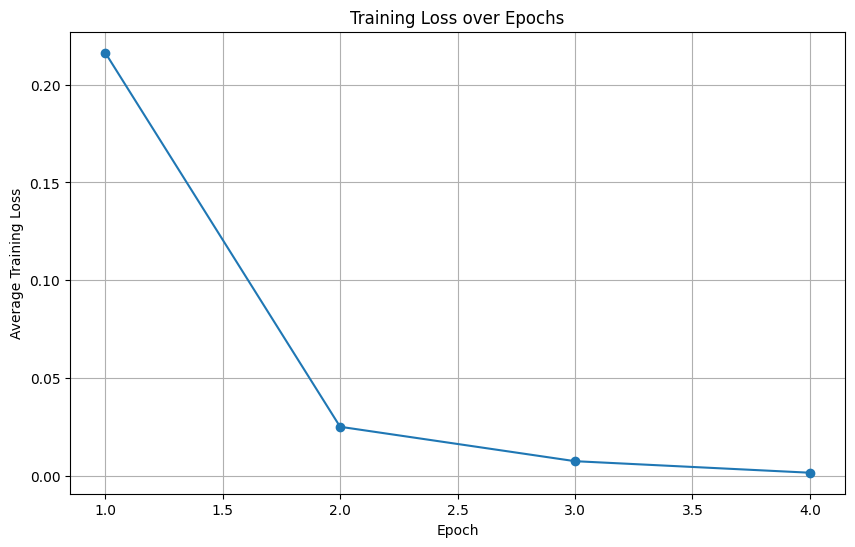

In [14]:
# Initialize an empty list to store the average training loss for each epoch
train_loss_values = []

num_epochs = 4
for epoch in range(num_epochs):
    print(f'Starting epoch {epoch+1}/{num_epochs}')
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        target_ids = batch[2].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_masks, labels=target_ids)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    train_loss_values.append(avg_train_loss)  # Store the average training loss
    print(f'Epoch {epoch+1}/{num_epochs} - Average training loss: {avg_train_loss}')
    mlflow.log_metric('train_loss', avg_train_loss, step=epoch + 1)

    # Evaluate the model
    bleu_score = evaluate_model(model, tokenizer, train_dataloader)
    print(f'Epoch {epoch+1}/{num_epochs} - BLEU score on train set: {bleu_score}')
    mlflow.log_metric('BLEU_score', bleu_score, step=epoch + 1)

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss_values, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.grid(True)
plt.show()

In [15]:
# Testing the model on test data set
bleu_score = evaluate_model(model, tokenizer, test_dataloader)
print(f'BLEU score on test set: {bleu_score}')
mlflow.log_metric('BLEU_score', bleu_score)

BLEU score on test set: 0.9973148817515233


In [16]:
tokenizer.save_pretrained("bert-translation-model-sql-json")
model.save_pretrained("bert-translation-model-sql-json")

In [17]:
mlflow.end_run()

In [18]:
from transformers import BertTokenizer, BertModel
import torch
from transformers import BertForMaskedLM
import torch.nn as nn
from sqlalchemy import create_engine, text
import os
import pandas as pd
import tkinter as tk
from tkinter import messagebox
import tkinter.ttk as ttk
import sys

model_path = "bert-translation-model-sql-json"
model = BertForMaskedLM.from_pretrained(model_path)

In [19]:
# Read data and create dataframe
df1 = pd.read_excel('dataTurkToSQL_splitter_dataV7.xlsx')
df2 = df1[["question", "sql", "split"]]
df3=df2.dropna().copy()
#display(df3)

In [20]:
list_of_questions = df3["question"].tolist()
#print(list_of_questions)

In [21]:
tokenizer = BertTokenizer.from_pretrained(model_path)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [22]:
def SQL_Query(question):
    encoded_question = tokenizer.encode(question, return_tensors='pt')

    with torch.no_grad():
        outputs = model(encoded_question)
        predictions = torch.argmax(outputs.logits, dim=-1)
        #display(outputs)
        #display(predictions)
    predicted_token = tokenizer.decode(predictions[0], skip_special_tokens=True)
    #display(predicted_token)
    # Add question and sql to a list
    data.append({"question": question, "sql": predicted_token})

# Initialize an empty list to store the data
data = []
for item in list_of_questions:
    SQL_Query(item)

# Create a DataFrame from the list of dictionaries
df6 = pd.DataFrame(data)
df6 = pd.concat([df6, df3["split"]], axis=1)
#display(df6)

In [23]:
df6.to_excel("QuestionsAndSql_TrainAndTest-dataV7.xlsx")

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
